In [54]:
import pandas as pd
import numpy as np
import json
# import psycopg2
# from sqlalchemy import create_engine
# import os
# from dotenv import load_dotenv
# load_dotenv()

# from script.database_pipeline import Pipeline
from script.helper import *

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Setting up DB

**Decided to put database on hold**

In [3]:
# username = os.getenv('PSQL_USER')
# password = os.getenv('PASS')
# host = os.getenv('HOST')
# port = os.getenv('PORT')

# db_url = (f"postgresql+psycopg2://{username}:{password}@{host}:{port}/data_prof")

In [4]:
# engine = create_engine(db_url)

In [5]:
# Converted into a csv
df = pd.read_csv('ds_2019.csv')

In [6]:
# pipe = Pipeline(engine)
# pipe.add_table(df, 'og')

### EDA

In the other two notebooks, I've found that salary is one of the features that the three groups, `not looking`, `passively looking`, and `actively looking` on. This is an attempt at a thorough salary analysis based previous findings.

### Looking at overall US

Breaking down into 3 groups

In [7]:
us = df[df['Country'] == 'United States'].copy()

In [8]:
us_cleaned = us.copy()

In [9]:
looking = us['LookingForAnotherJob'].value_counts().index

In [10]:
looking_map = { v: i for i, v in enumerate(looking)}

In [11]:
us_cleaned.loc[:, 'LookingForAnotherJob'] = us['LookingForAnotherJob'].map(looking_map)

In [275]:
features = ['SalaryUSD', 'PostalCode', 'YearsWithThisDatabase', 'YearsWithThisTypeOfJob', 'OtherPeopleOnYourTeam', \
             'Education', 'HoursWorkedPerWeek', \
            'Gender', 'EmploymentStatus']
target = ['LookingForAnotherJob']

### Salary

In [81]:
us_cleaned.loc[:, 'SalaryUSD'] = us['SalaryUSD'].apply(str).replace(',|\s+', '', regex=True).astype(float)

In [83]:
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]

In [84]:
nl_salary = nl_cleaned['SalaryUSD']
pl_salary = pl_cleaned['SalaryUSD']
al_salary = al_cleaned['SalaryUSD']

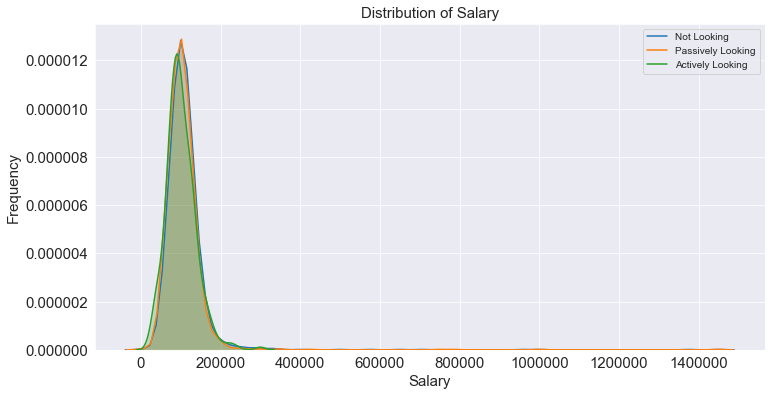

In [85]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_salary, pl_salary, al_salary, nl_label='Not Looking', pl_label='Passively Looking', al_label='Actively Looking', xlabel='Salary', ylabel='Frequency',
            title='Distribution of Salary'))

In [89]:
nl_salary_adj = outliers_removed(nl_salary)
pl_salary_adj = outliers_removed(pl_salary)
al_salary_adj = outliers_removed(al_salary)


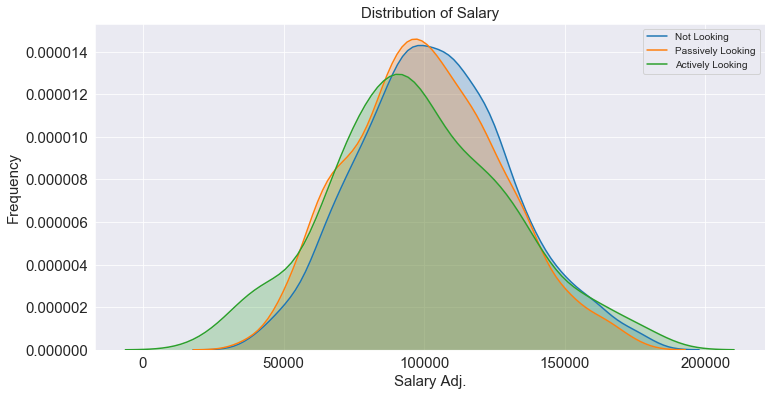

In [90]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_salary_adj, pl_salary_adj, al_salary_adj, nl_label='Not Looking', pl_label='Passively Looking', al_label='Actively Looking', xlabel='Salary Adj.', ylabel='Frequency',
            title='Distribution of Salary'))

## The analysis from this point on will mainly be looking at the salary without the outliers.

### PostalCodes

In [105]:
with open('postcodeclean.json', 'r') as f:
    results_combined = json.load(f)

In [106]:
def transform_zipcode(row):
    if row in results_combined:
        return results_combined[row]
    return row

In [109]:
us_cleaned.loc[:, 'States'] = us_cleaned['PostalCode'].apply(transform_zipcode)
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]

nl_salary_adj = outliers_removed(nl_salary)
pl_salary_adj = outliers_removed(pl_salary)
al_salary_adj = outliers_removed(al_salary)


#### Salary of top 5 states

In [113]:
top5_states = us_cleaned['States'].value_counts().index[1:6]

In [153]:
state_salary = [(nl_salary_adj[nl_cleaned['States'] == state], pl_salary_adj[pl_cleaned['States'] == state], al_salary_adj[al_cleaned['States'] == state]) for state in top5_states]


#### California

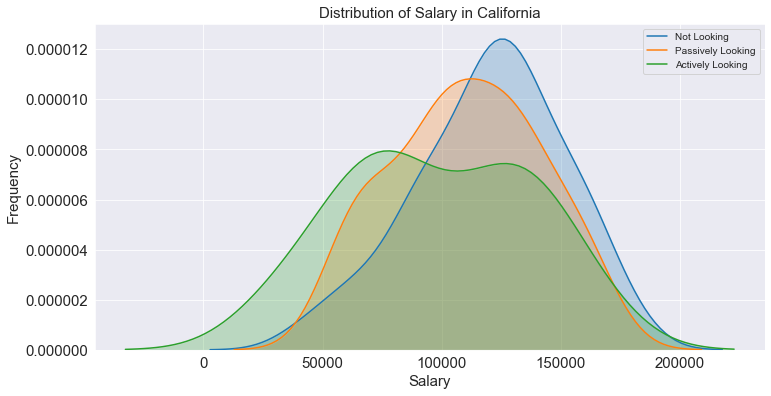

In [144]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, state_salary[0][0], state_salary[0][1], state_salary[0][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary in {top5_states[0]}')


#### Texas

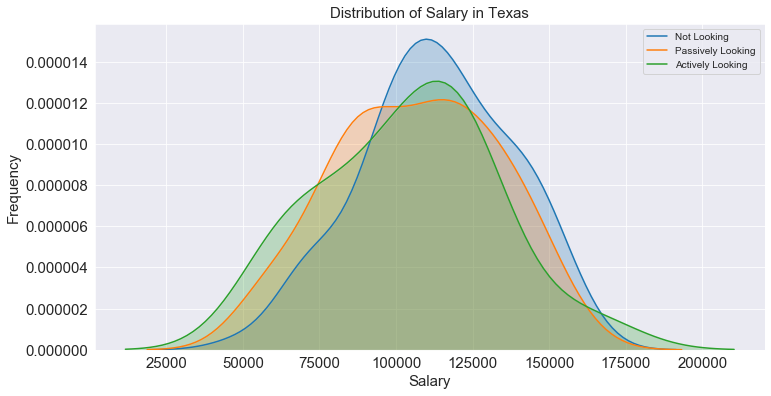

In [145]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, state_salary[1][0], state_salary[1][1], state_salary[1][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary in {top5_states[1]}')


#### Washington

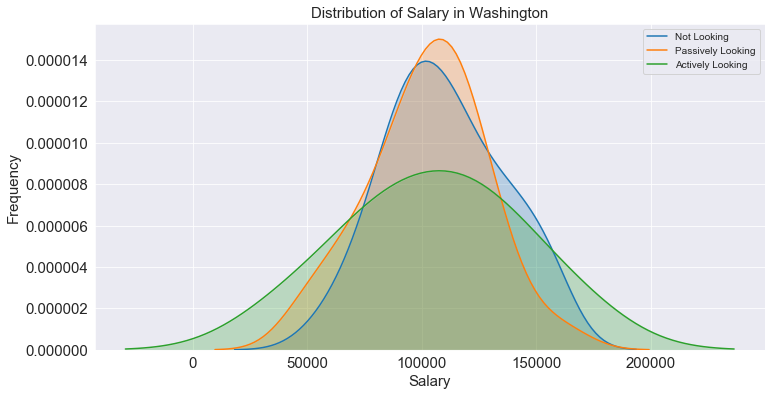

In [146]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, state_salary[2][0], state_salary[2][1], state_salary[2][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary in {top5_states[2]}')


#### Illinois

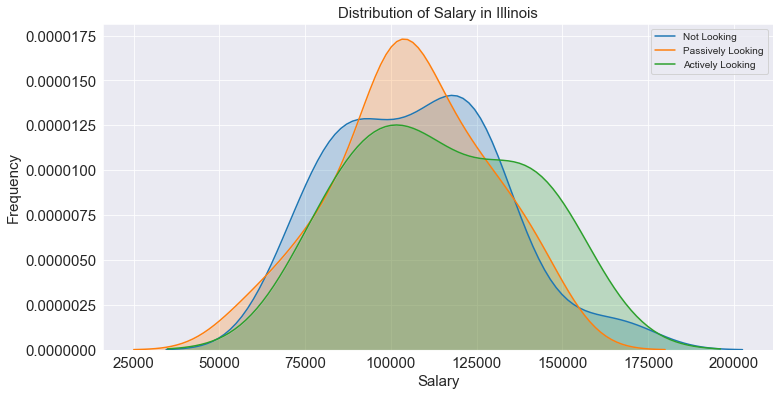

In [147]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, state_salary[3][0], state_salary[3][1], state_salary[3][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary in {top5_states[3]}')


#### Pennsylvania

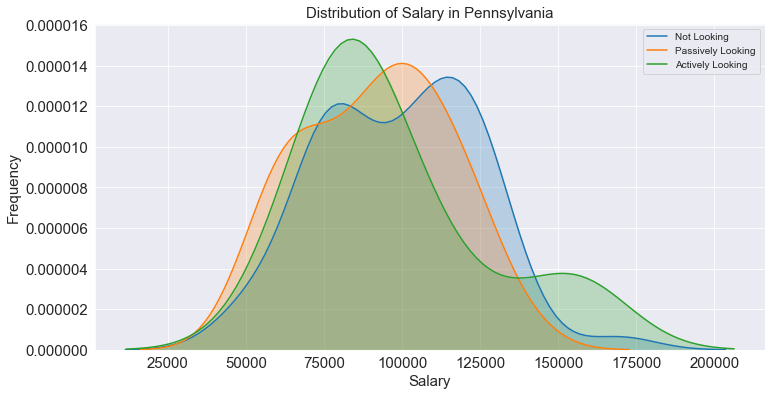

In [148]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, state_salary[4][0], state_salary[4][1], state_salary[4][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary in {top5_states[4]}')


### Employment Status

In [234]:
def transform_es(row):
    if ('Full' in row):
        return 'Full Time'
    elif ('Independent' in row):
        return 'Independent'
    else:
        return 'Part Time'

In [238]:
us_cleaned.loc[:, 'EmploymentStatus'] = us_cleaned.loc[:, 'EmploymentStatus'].apply(transform_es)
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]


In [242]:
nl_full = nl_salary_adj[nl_cleaned['EmploymentStatus'] == 'Full Time']
pl_full = pl_salary_adj[pl_cleaned['EmploymentStatus'] == 'Full Time']
al_full = al_salary_adj[al_cleaned['EmploymentStatus'] == 'Full Time']

nl_ind = nl_salary_adj[nl_cleaned['EmploymentStatus'] == 'Independent']
pl_ind = pl_salary_adj[pl_cleaned['EmploymentStatus'] == 'Independent']
al_ind = al_salary_adj[al_cleaned['EmploymentStatus'] == 'Independent']

nl_part = nl_salary_adj[nl_cleaned['EmploymentStatus'] == 'Part Time']
pl_part = pl_salary_adj[pl_cleaned['EmploymentStatus'] == 'Part Time']
al_part = al_salary_adj[al_cleaned['EmploymentStatus'] == 'Part Time']

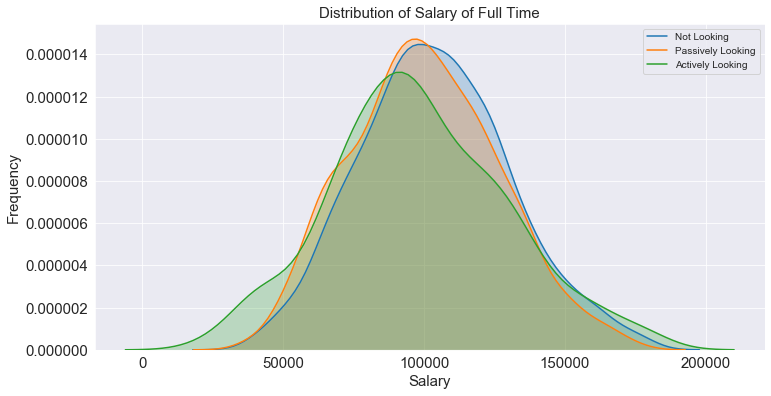

In [244]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_full, pl_full, al_full, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Full Time')


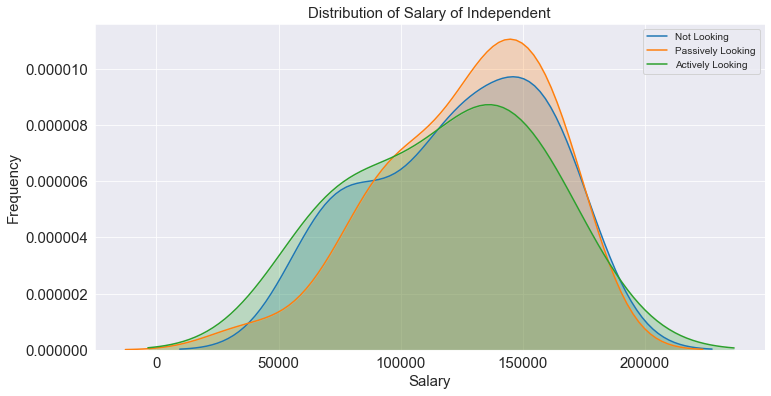

In [249]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_ind, pl_ind, al_ind, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Independent')


Not enough data to plot Part Time

/usr/local/anaconda3/envs/cap1/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/envs/cap1/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


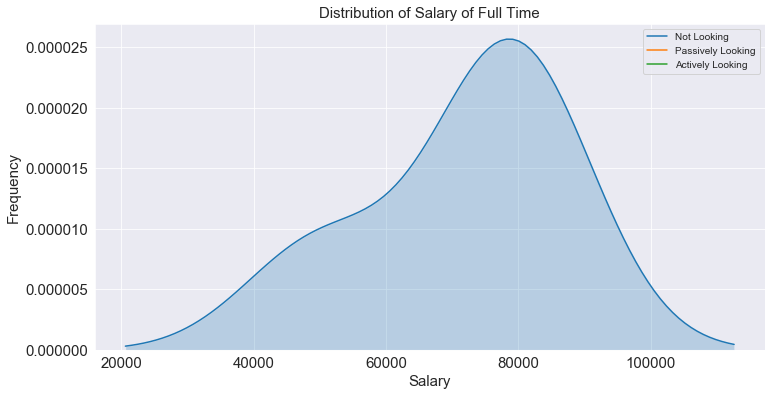

In [246]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_part, pl_part, al_part, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Full Time')


### Education

In [256]:
us_cleaned.loc[:, 'Education'] = us_cleaned['Education'].replace('\\(.*\\)', '', regex=True).str.strip()
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]


In [258]:
edu = ['None', 'Associates', 'Bachelors', 'Masters', 'Doctorate/PhD']

In [260]:
all_edu = [(nl_salary_adj[nl_cleaned['Education'] == e], pl_salary_adj[pl_cleaned['Education'] == e], al_salary_adj[al_cleaned['Education'] == e])for e in edu]



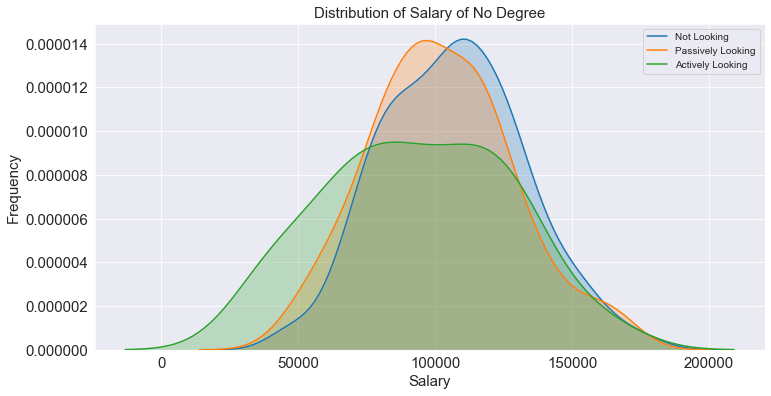

In [265]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, all_edu[0][0], all_edu[0][1], all_edu[0][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of No Degree')


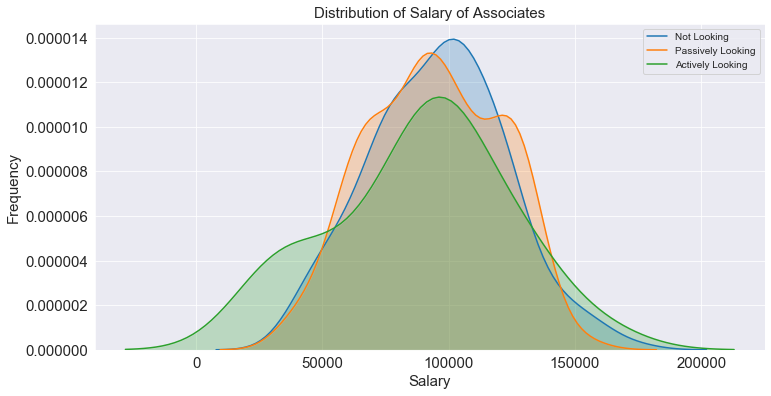

In [270]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, all_edu[1][0], all_edu[1][1], all_edu[1][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of {edu[1]}')


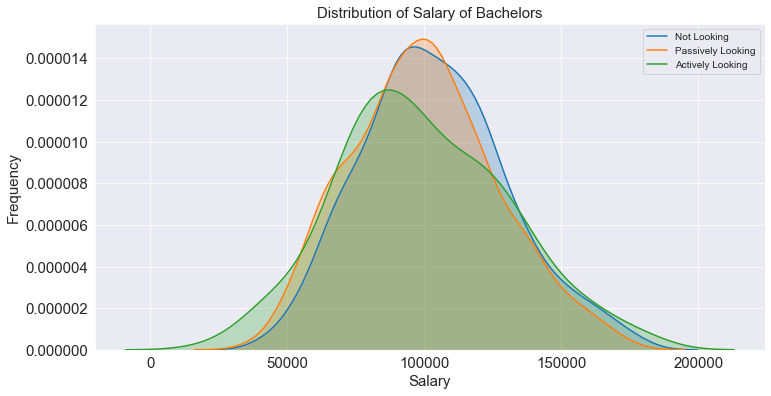

In [271]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, all_edu[2][0], all_edu[2][1], all_edu[2][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of {edu[2]}')


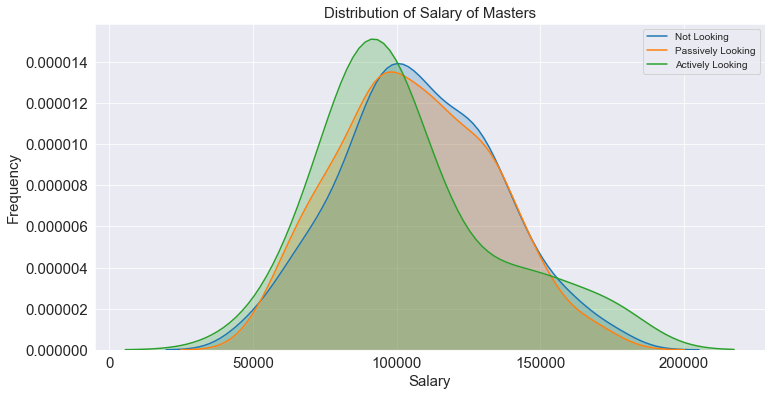

In [272]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, all_edu[3][0], all_edu[3][1], all_edu[3][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of {edu[3]}')


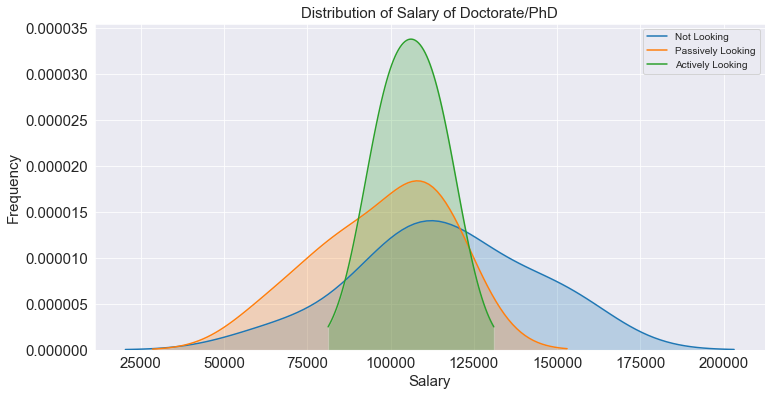

In [273]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, all_edu[4][0], all_edu[4][1], all_edu[4][2], xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of {edu[4]}')


### Years With This Database

In [162]:
# Clean out values with greater than 100
us_cleaned.loc[:, 'YearsWithThisDatabase'] = us_cleaned.loc[us_cleaned['YearsWithThisDatabase'] < 100, 'YearsWithThisDatabase']
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]


In [192]:
mean_yrdb = us_cleaned['YearsWithThisDatabase'].mean()

In [193]:
nl_yrdb_g = nl_salary_adj[(nl_cleaned['YearsWithThisDatabase'] >= mean_yrdb)]
pl_yrdb_g = pl_salary_adj[(pl_cleaned['YearsWithThisDatabase'] >= mean_yrdb)]
al_yrdb_g = al_salary_adj[(al_cleaned['YearsWithThisDatabase'] >= mean_yrdb)]

nl_yrdb_l = nl_salary_adj[(nl_cleaned['YearsWithThisDatabase'] < mean_yrdb)]
pl_yrdb_l = pl_salary_adj[(pl_cleaned['YearsWithThisDatabase'] < mean_yrdb)]
al_yrdb_l = al_salary_adj[(al_cleaned['YearsWithThisDatabase'] < mean_yrdb)]


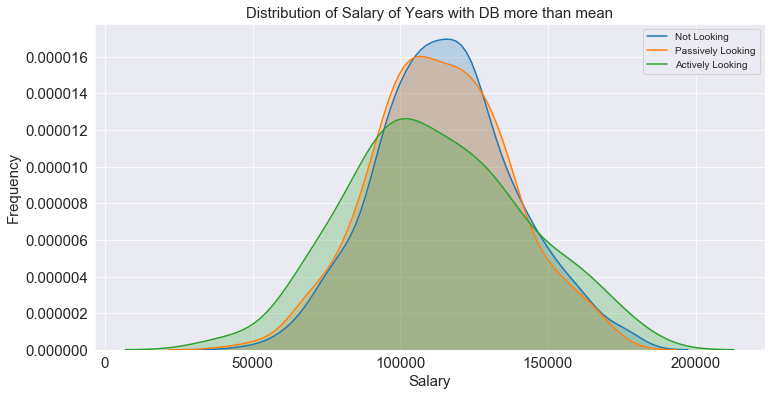

In [205]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_yrdb_g, pl_yrdb_g, al_yrdb_g, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Years with DB more than mean')


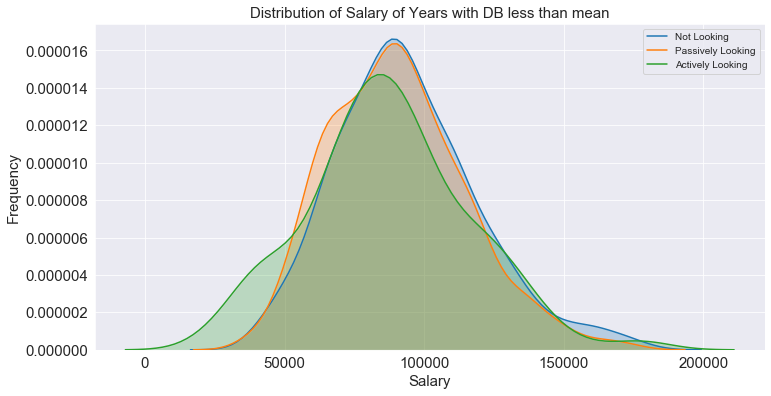

In [206]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_yrdb_l, pl_yrdb_l, al_yrdb_l, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Years with DB less than mean')


### YearsWithThisTypeOfJob

In [197]:
mean_yrjb = us_cleaned['YearsWithThisTypeOfJob'].mean()

In [198]:
nl_yrjb_g = nl_salary_adj[(nl_cleaned['YearsWithThisDatabase'] >= mean_yrjb)]
pl_yrjb_g = pl_salary_adj[(pl_cleaned['YearsWithThisDatabase'] >= mean_yrjb)]
al_yrjb_g = al_salary_adj[(al_cleaned['YearsWithThisDatabase'] >= mean_yrjb)]

nl_yrjb_l = nl_salary_adj[(nl_cleaned['YearsWithThisDatabase'] < mean_yrjb)]
pl_yrjb_l = pl_salary_adj[(pl_cleaned['YearsWithThisDatabase'] < mean_yrjb)]
al_yrjb_l = al_salary_adj[(al_cleaned['YearsWithThisDatabase'] < mean_yrjb)]


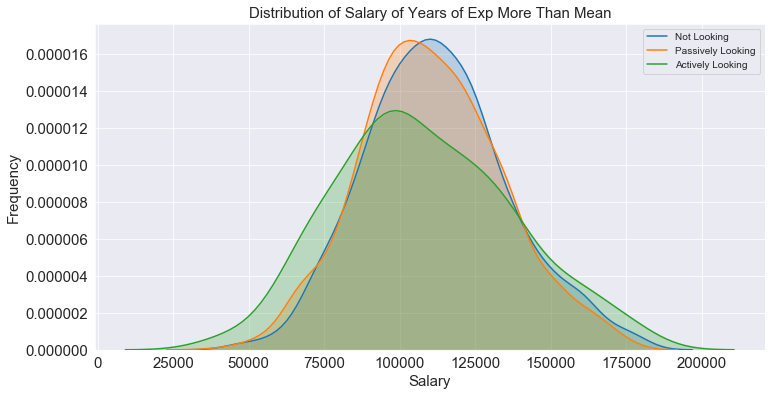

In [203]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_yrjb_g, pl_yrjb_g, al_yrjb_g, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Years of Exp More Than Mean')


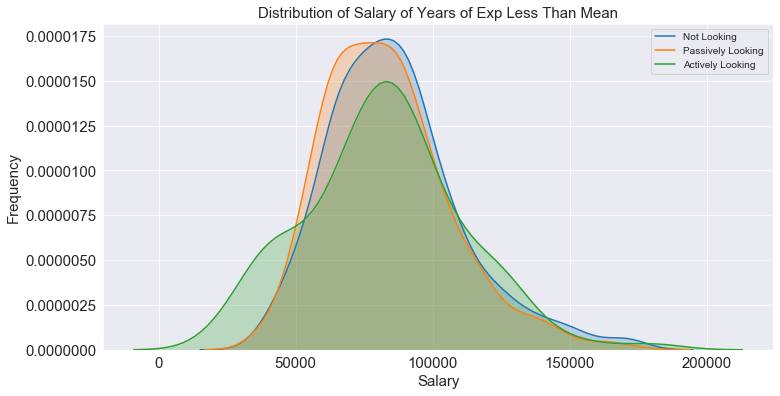

In [204]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_yrjb_l, pl_yrjb_l, al_yrjb_l, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Years of Exp Less Than Mean')


### OtherPeopleOnYourTeam

In [211]:
nl_mask0 = nl_cleaned['OtherPeopleOnYourTeam'] == 'None'
pl_mask0 = pl_cleaned['OtherPeopleOnYourTeam'] == 'None'
al_mask0 = al_cleaned['OtherPeopleOnYourTeam'] == 'None'

nl_mask1 = nl_cleaned['OtherPeopleOnYourTeam'] != 'None'
pl_mask1 = pl_cleaned['OtherPeopleOnYourTeam'] != 'None'
al_mask1 = al_cleaned['OtherPeopleOnYourTeam'] != 'None'


In [212]:
nl_nopoyt = nl_salary_adj[nl_mask0]
pl_nopoyt = pl_salary_adj[pl_mask0]
al_nopoyt = al_salary_adj[al_mask0]

nl_opoyt = nl_salary_adj[nl_mask1]
pl_opoyt = pl_salary_adj[pl_mask1]
al_opoyt = al_salary_adj[al_mask1]


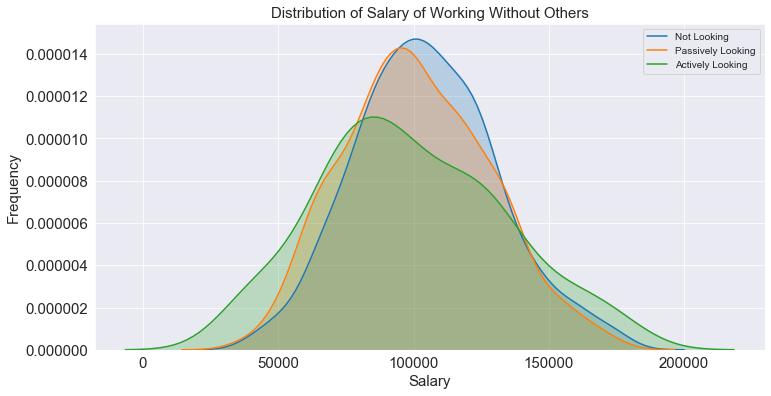

In [213]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_nopoyt, pl_nopoyt, al_nopoyt, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Working Without Others')


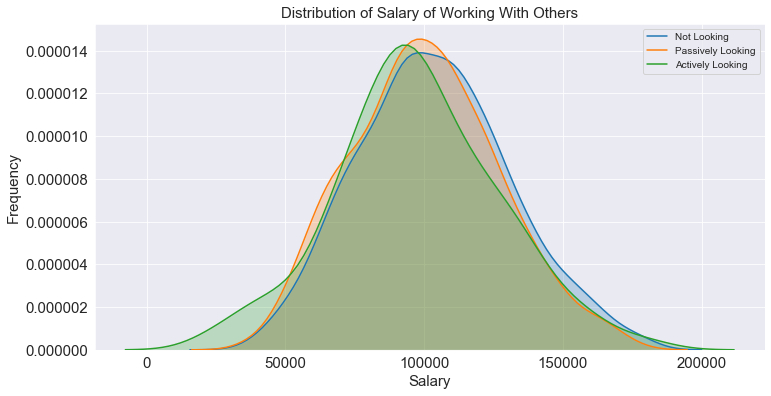

In [214]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_opoyt, pl_opoyt, al_opoyt, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Working With Others')


### HoursWorkedPerWeek

In [217]:
mean_hours = us_cleaned['HoursWorkedPerWeek'].mean()

In [220]:
nl_hours_g = nl_salary_adj[(nl_cleaned['HoursWorkedPerWeek'] >= mean_hours)]
pl_hours_g = pl_salary_adj[(pl_cleaned['HoursWorkedPerWeek'] >= mean_hours)]
al_hours_g = al_salary_adj[(al_cleaned['HoursWorkedPerWeek'] >= mean_hours)]

nl_hours_l = nl_salary_adj[(nl_cleaned['HoursWorkedPerWeek'] < mean_hours)]
pl_hours_l = pl_salary_adj[(pl_cleaned['HoursWorkedPerWeek'] < mean_hours)]
al_hours_l = al_salary_adj[(al_cleaned['HoursWorkedPerWeek'] < mean_hours)]

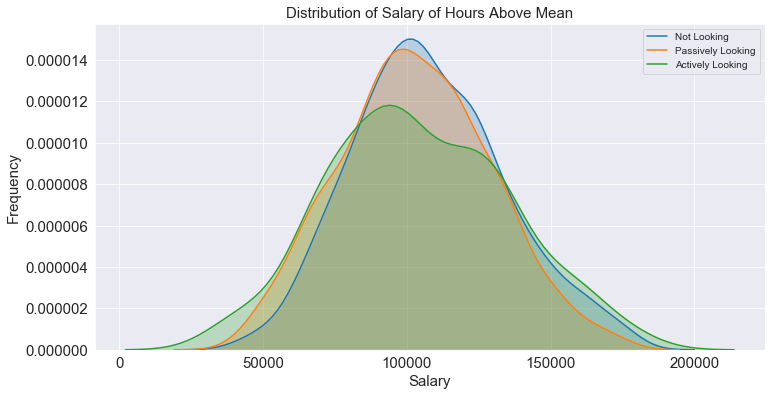

In [223]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_hours_g, pl_hours_g, al_hours_g, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Hours Above Mean')


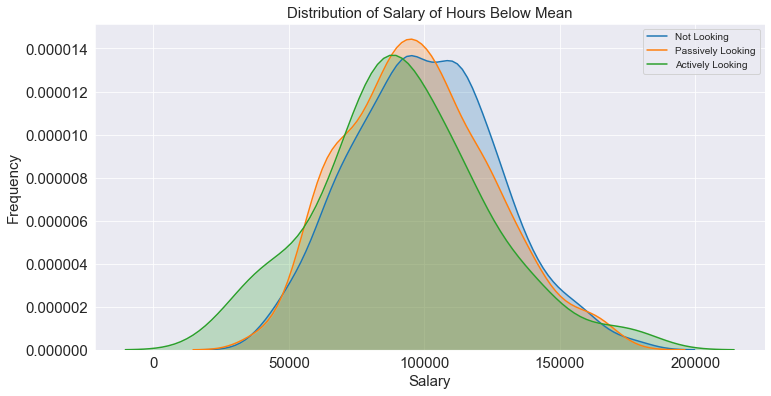

In [224]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_hours_l, pl_hours_l, al_hours_l, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Hours Below Mean')


### Gender

In [228]:
nl_mask_m = nl_cleaned['Gender'] == 'Male'
pl_mask_m = pl_cleaned['Gender'] == 'Male'
al_mask_m = al_cleaned['Gender'] == 'Male'

nl_mask_f = nl_cleaned['Gender'] == 'Female'
pl_mask_f = pl_cleaned['Gender'] == 'Female'
al_mask_f = al_cleaned['Gender'] == 'Female'


In [229]:
nl_gender_m = nl_salary_adj[nl_mask_m]
pl_gender_m = pl_salary_adj[pl_mask_m]
al_gender_m = al_salary_adj[al_mask_m]

nl_gender_f = nl_salary_adj[nl_mask_f]
pl_gender_f = pl_salary_adj[pl_mask_f]
al_gender_f = al_salary_adj[al_mask_f]


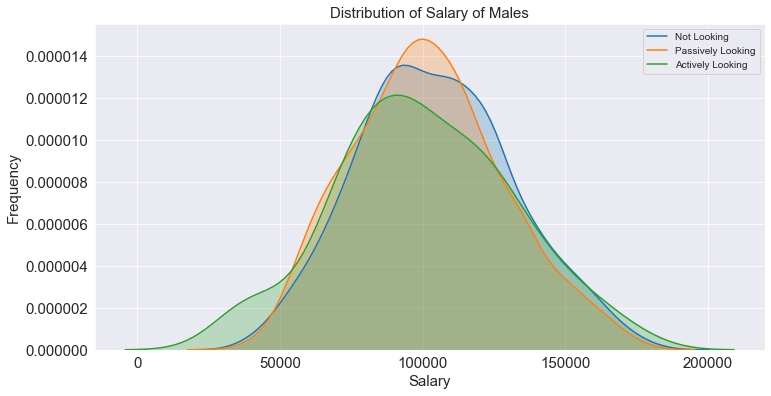

In [230]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_gender_m, pl_gender_m, al_gender_m, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Males')


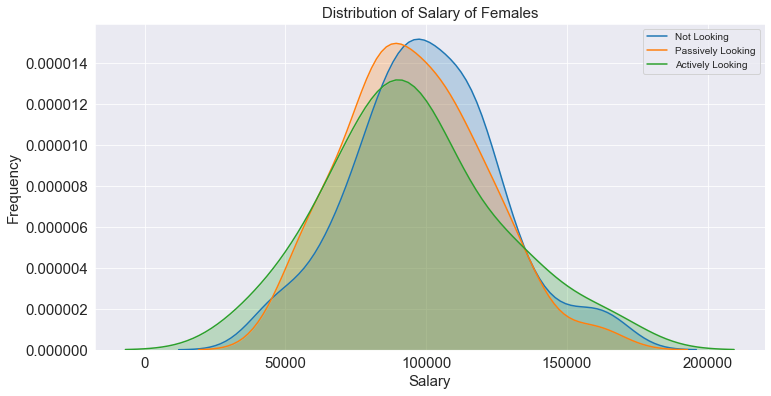

In [231]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_kde(ax, nl_gender_f, pl_gender_f, al_gender_f, xlabel='Salary', ylabel='Frequency',
             title=f'Distribution of Salary of Females')


In [279]:
features += ['States']

### Feature Engineering

In [280]:
X = us_cleaned.loc[:, features + target]

In [281]:
X.head()

,SalaryUSD,PostalCode,YearsWithThisDatabase,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,Education,HoursWorkedPerWeek,Gender,EmploymentStatus,States,LookingForAnotherJob
0,200000.0,Not Asked,10.0,5,2,Masters,45,Not Asked,Full Time,Not Asked,1
12,137500.0,Not Asked,16.0,6,4,None,55,Not Asked,Full Time,Not Asked,0
14,85000.0,Not Asked,8.0,2,None,Bachelors,50,Not Asked,Full Time,Not Asked,1
15,96000.0,Not Asked,5.0,5,None,Masters,45,Not Asked,Full Time,Not Asked,1
17,66000.0,Not Asked,10.0,10,None,Associates,60,Not Asked,Full Time,Not Asked,1


### SalaryUSD

Cleaning erroneous values

In [282]:
X = X.drop(X[X['SalaryUSD'] < 100].index)

In [283]:
X.head()

,SalaryUSD,PostalCode,YearsWithThisDatabase,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,Education,HoursWorkedPerWeek,Gender,EmploymentStatus,States,LookingForAnotherJob
0,200000.0,Not Asked,10.0,5,2,Masters,45,Not Asked,Full Time,Not Asked,1
12,137500.0,Not Asked,16.0,6,4,None,55,Not Asked,Full Time,Not Asked,0
14,85000.0,Not Asked,8.0,2,None,Bachelors,50,Not Asked,Full Time,Not Asked,1
15,96000.0,Not Asked,5.0,5,None,Masters,45,Not Asked,Full Time,Not Asked,1
17,66000.0,Not Asked,10.0,10,None,Associates,60,Not Asked,Full Time,Not Asked,1


### PostalCode

In [284]:
X = X.drop('PostalCode', axis=1)

In [285]:
X.head()

,SalaryUSD,YearsWithThisDatabase,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,Education,HoursWorkedPerWeek,Gender,EmploymentStatus,States,LookingForAnotherJob
0,200000.0,10.0,5,2,Masters,45,Not Asked,Full Time,Not Asked,1
12,137500.0,16.0,6,4,None,55,Not Asked,Full Time,Not Asked,0
14,85000.0,8.0,2,None,Bachelors,50,Not Asked,Full Time,Not Asked,1
15,96000.0,5.0,5,None,Masters,45,Not Asked,Full Time,Not Asked,1
17,66000.0,10.0,10,None,Associates,60,Not Asked,Full Time,Not Asked,1


### OtherPeopleOnYourTeam

In [78]:
others_map = {'None': 0, 
              '1': 1, 
              '2': 2,
              '3': 3,
              '4': 4,
              '5': 5,
             'More than 5': 6}

In [79]:
X.loc[:, 'OtherPeopleOnYourTeam'] = X['OtherPeopleOnYourTeam'].map(others_map)

In [80]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,DBA,0,5,2,350,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,DBA,0,6,4,200,None,55,5 or more,Private business,Not Asked,Not Asked,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,DBA,0,2,0,15,Bachelors,50,"None, or less than 1 day per week",Private business,Not Asked,Not Asked,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,DBA,0,5,0,100,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,Developer,0,10,0,4,Associates,60,5 or more,Private business,Not Asked,Not Asked,7.0,NaN,1,Not Asked


### Education

In [81]:
edu_map = {
    'None': 0,
    'Associates': 1,
    'Bachelors': 2,
    'Masters': 3,
    'Doctorate/PhD': 4
}

In [82]:
X.loc[:, 'Education'] = X['Education'].map(edu_map)

In [83]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,DBA,0,5,2,350,3,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,DBA,0,6,4,200,0,55,5 or more,Private business,Not Asked,Not Asked,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,DBA,0,2,0,15,2,50,"None, or less than 1 day per week",Private business,Not Asked,Not Asked,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,DBA,0,5,0,100,3,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,Developer,0,10,0,4,1,60,5 or more,Private business,Not Asked,Not Asked,7.0,NaN,1,Not Asked


### Gender

In [92]:
gender_map = {
    'Female': 0,
    'Male': 1,
    'Other': 3,
    'Not Asked': np.nan
}

In [93]:
X.loc[:, 'Gender'] = X['Gender'].map(gender_map)

In [94]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,DBA,0,5,2,350,3,45,1,0,NaN,Not Asked,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,DBA,0,6,4,200,0,55,5,0,NaN,Not Asked,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,DBA,0,2,0,15,2,50,0,0,NaN,Not Asked,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,DBA,0,5,0,100,3,45,1,0,NaN,Not Asked,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,Developer,0,10,0,4,1,60,5,0,NaN,Not Asked,7.0,NaN,1,Not Asked


**Splitting into 3 groups**

In [106]:
not_looking = X[X['LookingForAnotherJob'] == 0]
passively_looking = X[X['LookingForAnotherJob'] == 1]
actively_looking = X[X['LookingForAnotherJob'] == 2]

In [107]:
not_looking.isna().mean(), not_looking.shape

(SalaryUSD                 0.000000
 YearsWithThisDatabase     0.000850
 PrimaryDatabase           0.000000
 JobTitle                  0.000000
 ManageStaff               0.000000
 YearsWithThisTypeOfJob    0.000000
 OtherPeopleOnYourTeam     0.000000
 DatabaseServers           0.000000
 Education                 0.000000
 HoursWorkedPerWeek        0.000000
 TelecommuteDaysPerWeek    0.000000
 EmploymentSector          0.000000
 Gender                    0.405187
 od_count                  0.209184
 ojd_count                 0.405187
 LookingForAnotherJob      0.000000
 PostalCodeStates          0.069728
 dtype: float64, (2352, 17))

In [108]:
passively_looking.isna().mean(), passively_looking.shape

(SalaryUSD                 0.000000
 YearsWithThisDatabase     0.001623
 PrimaryDatabase           0.000000
 JobTitle                  0.000000
 ManageStaff               0.000000
 YearsWithThisTypeOfJob    0.000000
 OtherPeopleOnYourTeam     0.000000
 DatabaseServers           0.000000
 Education                 0.000000
 HoursWorkedPerWeek        0.000000
 TelecommuteDaysPerWeek    0.000000
 EmploymentSector          0.000000
 Gender                    0.437771
 od_count                  0.173701
 ojd_count                 0.437771
 LookingForAnotherJob      0.000000
 PostalCodeStates          0.066017
 dtype: float64, (1848, 17))

In [109]:
actively_looking.isna().mean(), actively_looking.shape

(SalaryUSD                 0.000000
 YearsWithThisDatabase     0.000000
 PrimaryDatabase           0.000000
 JobTitle                  0.000000
 ManageStaff               0.000000
 YearsWithThisTypeOfJob    0.000000
 OtherPeopleOnYourTeam     0.000000
 DatabaseServers           0.000000
 Education                 0.000000
 HoursWorkedPerWeek        0.000000
 TelecommuteDaysPerWeek    0.000000
 EmploymentSector          0.000000
 Gender                    0.379870
 od_count                  0.194805
 ojd_count                 0.379870
 LookingForAnotherJob      0.000000
 PostalCodeStates          0.051948
 dtype: float64, (308, 17))

### Testing, with a p value of 0.05

In [110]:
import scipy.stats as stats

#### Salary

In [111]:
nl_salary = not_looking['SalaryUSD']
pl_salary = passively_looking['SalaryUSD']
al_salary = actively_looking['SalaryUSD']

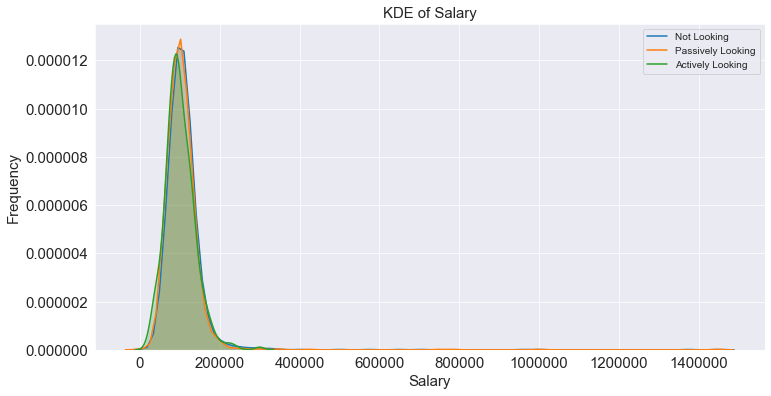

In [112]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_salary, pl_salary, al_salary, xlabel='Salary', ylabel='Frequency',
            title='KDE of Salary'))

In [113]:
nl_adj = outliers_removed(nl_salary)
pl_adj = outliers_removed(pl_salary)
al_adj = outliers_removed(al_salary)

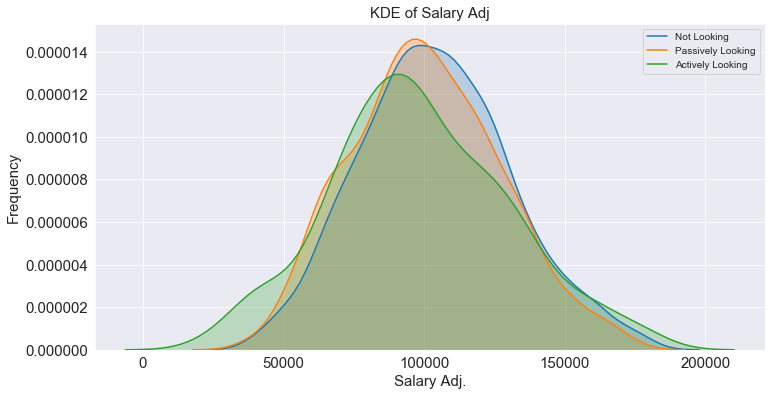

In [114]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_adj, pl_adj, al_adj, xlabel='Salary Adj.', ylabel='Frequency',
            title='KDE of Salary Adj'))

In [115]:
samps_ttest(not_looking['SalaryUSD'], passively_looking['SalaryUSD'], actively_looking['SalaryUSD'])

(('nl, pl', 0.0050872592302549716),
 ('pl, al', 0.10604738596970431),
 ('nl, al', 0.00024136075989482922))

In [116]:
samps_ttest(nl_adj, pl_adj, al_adj)

(('nl, pl', 3.706378998902741e-05),
 ('pl, al', 0.22117481672058284),
 ('nl, al', 0.002313316350332261))

In [117]:
# Not usable due to unequal variance
# stats.f_oneway(nl_adj, pl_adj, al_adj)

**Conclusion:**

Without adjusting for outliers, there is only difference between those who are not looking and those who are actively. While passively looking does not have any differences to the other two.

Adjusting for outliers, there is a difference between not looking and those who are looking, whether it'd be passive or actively.

#### Years With This Database

In [118]:
nl_yrdb = not_looking['YearsWithThisDatabase']
pl_yrdb = passively_looking['YearsWithThisDatabase']
al_yrdb = actively_looking['YearsWithThisDatabase']

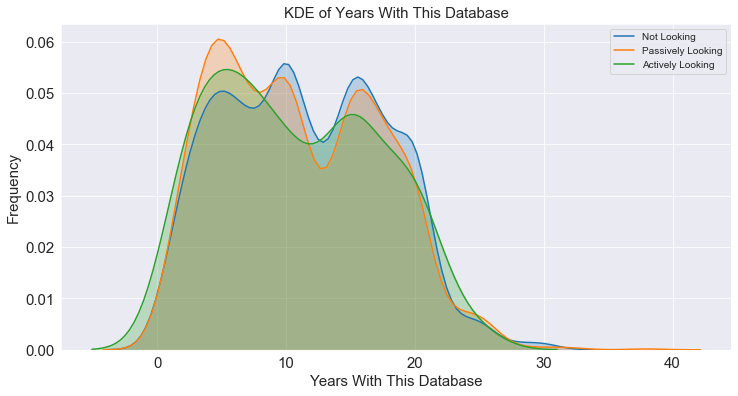

In [119]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_yrdb, pl_yrdb, al_yrdb, xlabel='Years With This Database', ylabel='Frequency',
            title='KDE of Years With This Database'))

In [120]:
samps_mwu(nl_yrdb, pl_yrdb, al_yrdb)

(('nl, pl', 0.004014591507134288),
 ('pl, al', 0.313014490260527),
 ('nl, al', 0.038738534681703254))

**Conclusions:**  

There is a difference in years with the database between those not looking and all those who are looking.

#### Primary Database

In [121]:
nl_pd = not_looking['PrimaryDatabase']
pl_pd = passively_looking['PrimaryDatabase']
al_pd = actively_looking['PrimaryDatabase']

In [122]:
p = samps_chi2(nl_pd, pl_pd, al_pd)

In [123]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


#### Job Title

In [124]:
nl_jt = not_looking['JobTitle']
pl_jt = passively_looking['JobTitle']
al_jt = actively_looking['JobTitle']

In [125]:
p = samps_chi2(nl_jt, pl_jt, al_jt)

In [126]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


#### Other Databases Count

In [127]:
nl_od = not_looking['od_count']
pl_od = passively_looking['od_count']
al_od = actively_looking['od_count']

In [128]:
p = samps_chi2(nl_od, pl_od, al_od)

In [129]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


#### Manage Staff

In [130]:
nl_ms = not_looking['ManageStaff']
pl_ms = passively_looking['ManageStaff']
al_ms = actively_looking['ManageStaff']

In [131]:
p = samps_chi2(nl_ms, pl_ms, al_ms)

In [132]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


#### Years With This Type of Job

In [133]:
nl_yrjob = not_looking['YearsWithThisTypeOfJob']
pl_yrjob = passively_looking['YearsWithThisTypeOfJob']
al_yrjob = actively_looking['YearsWithThisTypeOfJob']

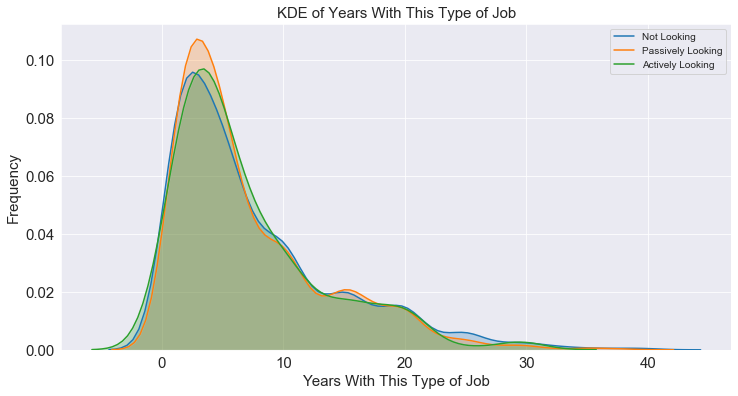

In [134]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_yrjob, pl_yrjob, al_yrjob, xlabel='Years With This Type of Job', ylabel='Frequency',
            title='KDE of Years With This Type of Job'))

In [135]:
samps_mwu(nl_yrjob, pl_yrjob, al_yrjob)

(('nl, pl', 0.2693892605440542),
 ('pl, al', 0.43486830424286727),
 ('nl, al', 0.3123631125279852))

**Conclusion:**

No differences at all.

#### Other People On Your Team

In [136]:
nl_people = not_looking['OtherPeopleOnYourTeam']
pl_people = passively_looking['OtherPeopleOnYourTeam']
al_people = actively_looking['OtherPeopleOnYourTeam']

In [137]:
p = samps_chi2(nl_people, pl_people, al_people)

In [138]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


#### Education

In [139]:
nl_edu = not_looking['Education']
pl_edu = passively_looking['Education']
al_edu = actively_looking['Education']

In [140]:
p = samps_chi2(nl_edu, pl_edu, al_edu)

In [141]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


#### Hours of Work Per Week

In [142]:
nl_hours = not_looking['HoursWorkedPerWeek']
pl_hours = passively_looking['HoursWorkedPerWeek']
al_hours = actively_looking['HoursWorkedPerWeek']

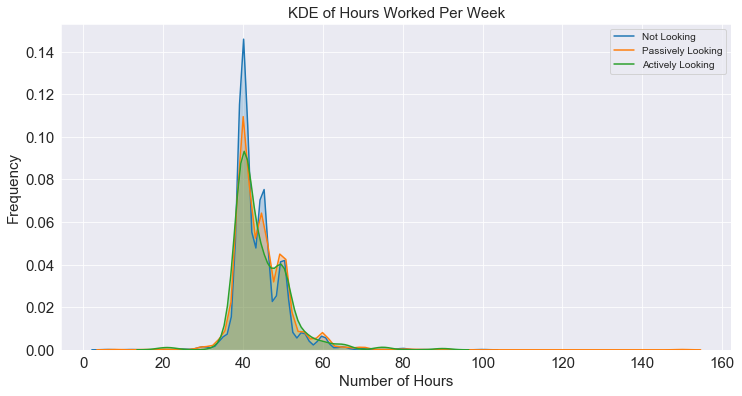

In [143]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_hours, pl_hours, al_hours, xlabel='Number of Hours', ylabel='Frequency',
            title='KDE of Hours Worked Per Week'))

In [144]:
samps_mwu(nl_hours, pl_hours, al_hours)

(('nl, pl', 0.00021368578539696515),
 ('pl, al', 0.32743508474272764),
 ('nl, al', 0.09966110859741123))

**Conclusion:**

A difference between not looking and passively looking, but no differences otherwise.

#### Telecommute Days Per Week

In [145]:
nl_tele = not_looking['TelecommuteDaysPerWeek']
pl_tele = passively_looking['TelecommuteDaysPerWeek']
al_tele = actively_looking['TelecommuteDaysPerWeek']

In [146]:
p = samps_chi2(nl_tele, pl_tele, al_tele)

In [147]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


#### Employment Sector

In [148]:
nl_emp = not_looking['EmploymentSector']
pl_emp = passively_looking['EmploymentSector']
al_emp = actively_looking['EmploymentSector']

In [149]:
p = samps_chi2(nl_emp, pl_emp, al_emp)

In [150]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


#### Gender

In [151]:
nl_gender = not_looking['Gender']
pl_gender = passively_looking['Gender']
al_gender = actively_looking['Gender']

In [152]:
p = samps_chi2(nl_gender, pl_gender, al_gender)

In [153]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


#### Other Job Duties count

In [154]:
nl_ojd = not_looking['ojd_count']
pl_ojd = passively_looking['ojd_count']
al_ojd = actively_looking['ojd_count']

In [155]:
p = samps_chi2(nl_ojd, pl_ojd, al_ojd)

In [156]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


#### Postal Code

In [157]:
nl_pc = not_looking['PostalCodeStates']
pl_pc = passively_looking['PostalCodeStates']
al_pc = actively_looking['PostalCodeStates']

In [158]:
p = samps_chi2(nl_pc, pl_pc, al_pc)

In [159]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


### Future plans

In [615]:
# countries_more_than_ten = countries.index[countries > 10]
# df = df[df['Country'].isin(countries_more_than_ten)]
# df.head()

### Predictive pipelines